In [347]:
import numpy as np
import pandas as pd

import h5py
import os
import sys
from tqdm import tqdm
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import gridspec

import astropy.units as u
import astropy.constants as C
import peters
from IPython.core.debugger import set_trace
from importlib import reload


colors = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']
#colors = sns.color_palette("Set2", n_colors=9)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [348]:
hyperparam_dict = {'p0':{0:r'$\chi_\mathrm{b}=0.0$', 1:r'$\chi_\mathrm{b}=0.1$', 2:r'$\chi_\mathrm{b}=0.2$', 3:r'$\chi_\mathrm{b}=0.5$'}, 
                   'p1':{0:r'$\alpha_\mathrm{CE}=0.2$', 1:r'$\alpha_\mathrm{CE}=0.5$', 2:r'$\alpha_\mathrm{CE}=1.0$', 3:r'$\alpha_\mathrm{CE}=2.0$', 4:r'$\alpha_\mathrm{CE}=5.0$'}, 
                   'beta_CE': r'$\beta_\mathrm{CE}$', 'beta_CHE': r'$\beta_\mathrm{CHE}$', 'beta_GC': r'$\beta_\mathrm{GC}$', 'beta_NSC': r'$\beta_\mathrm{NSC}$', 'beta_SMT': r'$\beta_\mathrm{SMT}$'}

In [349]:
data_path = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_no190521'
data_path_CEGC = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CEGC_no190521'
data_path_CESMT = '/Users/michaelzevin/research/model_selection/model_selection/trials/gwobs_CESMT_no190521'

fig_path = '/Users/michaelzevin/research/model_selection/model_selection/paper/figures/'

In [350]:
# get the hdf5 files for default runs
run_files = os.listdir(data_path)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path, file), key='model_selection/samples')
    samples = samples.append(tmp)
    
samples = samples.reset_index(drop=True)


# get the hdf5 files for 2-channel runs
run_files = os.listdir(data_path_CEGC)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CEGC = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CEGC, file), key='model_selection/samples')
    samples_CEGC = samples_CEGC.append(tmp)
    
samples_CEGC = samples_CEGC.reset_index(drop=True)


# get the hdf5 files for the 2-channel CESMT run
run_files = os.listdir(data_path_CESMT)
sample_files = []
for file in run_files:
    if '.hdf5' in file:
        sample_files.append(file)
        
samples_CESMT = pd.DataFrame()

for file in sample_files:
    tmp = pd.read_hdf(os.path.join(data_path_CESMT, file), key='model_selection/samples')
    samples_CESMT = samples_CESMT.append(tmp)
    
samples_CESMT = samples_CESMT.reset_index(drop=True)

In [402]:
def twochannel_branching_fractions(samples, hyperidx, prior_path, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2,2, hspace=0.6)
    
    beta_axs = []
    for idx in np.arange(len(beta_keys)):
        beta_axs.append(fig.add_subplot(gs[0,idx]))

    Bmax_ax = fig.add_subplot(gs[1,:])
    

    ### TOP ROW
    # loop through hyperparameter values
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]

        # loops through channels
        for idx, beta in enumerate(beta_keys):
            if idx==0:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey], label=hval)
            else:
                h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                h = np.append(h, [0])
                beta_axs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors[hkey])
                
    # plot total branching fraction
    for idx, beta in enumerate(beta_keys):
        h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
        h = np.append(h, [0])
        beta_axs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
        print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta,np.median(samples[beta]), \
                            np.median(samples[beta])-np.percentile(samples[beta],5), np.percentile(samples[beta],95)-np.median(samples[beta])))
            
    # format plot
    for idx, ax in enumerate(beta_axs):
        
        ax.set_xlim(0,1)
        ax.set_xticks((0.0, 0.25, 0.5, 0.75, 1.0))
        ax.set_yscale('log')
        ax.set_ylim(1e-5, 1e-1)
        ax.set_yticks((1e-5, 1e-4, 1e-3, 1e-2, 1e-1))
        
        ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=8)
        if idx==0:
            ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='both', labelsize=ticksize)
        
    # legend
    if hyperidx_key=='p0':
        fig.legend(bbox_to_anchor=(0.52, 0.90), loc='center', ncol=2, prop={'size':legendsize})
    elif hyperidx_key=='p1':
        fig.legend(bbox_to_anchor=(0.45, 1.0), loc='center', ncol=len(hyperparam_dict[hyperidx_key].keys()), prop={'size':legendsize})
        
            
    ### BOTTOM ROW
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
    print("Maximum beta is <{:0.3f} at the 99% credible level".format(np.percentile(max_betas, 99)))
    
    # get max beta for prior samples
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [h[-1]])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)

    
    # get max betas for submodels
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        betas = samples_in_hypermodel[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        Bmax_ax.step(bins, h/len(samples), color=colors[hkey], alpha=0.7, lw=4)
        
    # format plot
    Bmax_ax.set_xlim(1/len(beta_keys),1)
    Bmax_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bmax_ax.set_ylim(0, 0.06)
    Bmax_ax.set_yticks((0, 0.02, 0.04, 0.06))

    Bmax_ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize, labelpad=8)
    Bmax_ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize)
    Bmax_ax.tick_params(axis='both', labelsize=ticksize)
    
    Bmax_ax.legend(prop={'size': legendsize-3}, loc='center', bbox_to_anchor=(0.78, 0.67))
    
        
    # print Bayes factors
    samples0 = samples.loc[samples[hyperidx_key]==0]
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        BF = len(samples_in_hypermodel) / len(samples0)
        print("   For {:s} model, BF={:0.5f}".format(hval,BF))
        
    
            
    plt.subplots_adjust(bottom=0.14, top=0.80, right=0.96)
        
    plt.savefig(os.path.join(fig_path, 'beta_CEGC.png'))

beta_CE: 0.402-0.204+0.198
beta_GC: 0.598-0.198+0.204
Maximum beta is <0.859 at the 99% credible level
   For $\chi_\mathrm{b}=0.0$ model, BF=1.00000
   For $\chi_\mathrm{b}=0.1$ model, BF=0.98461
   For $\chi_\mathrm{b}=0.2$ model, BF=0.05291
   For $\chi_\mathrm{b}=0.5$ model, BF=0.00000


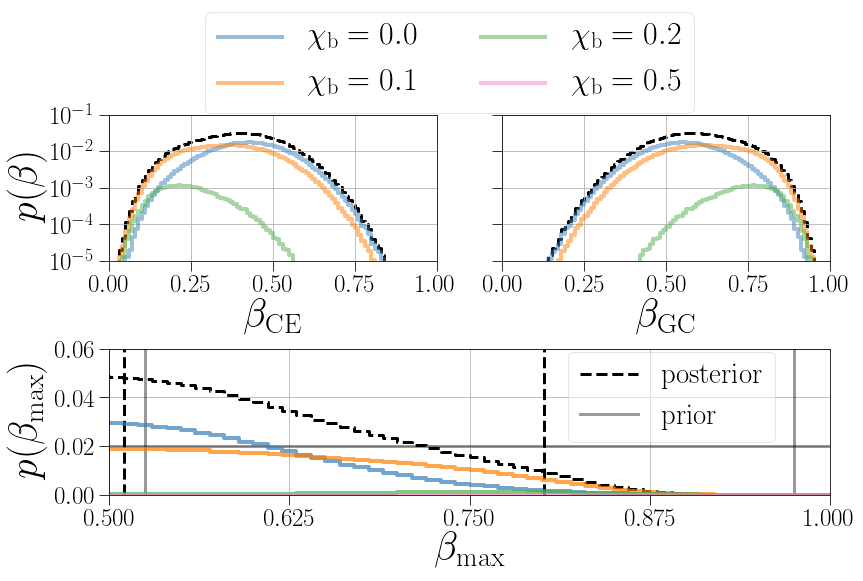

In [403]:
twochannel_branching_fractions(samples_CEGC, 0, \
                         prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/prior/prior_samples_2channel.hdf5', \
                              labelsize=40, ticksize=25, legendsize=32)

In [360]:
# print BFs for CESMT runs
print('Bayes factors for CESMT run...')

# print Bayes factors
samples0 = samples_CESMT.loc[samples_CESMT['p1']==2]
for (hkey, hval) in hyperparam_dict['p1'].items():
    samples_in_hypermodel = samples_CESMT.loc[samples_CESMT['p1']==hkey]
    BF = len(samples_in_hypermodel) / len(samples0)
    print("   For {:s} model, BF={:0.5f}".format(hval,BF))


Bayes factors for CESMT run...
   For $\alpha_\mathrm{CE}=0.2$ model, BF=0.01083
   For $\alpha_\mathrm{CE}=0.5$ model, BF=9240.86643
   For $\alpha_\mathrm{CE}=1.0$ model, BF=1.00000
   For $\alpha_\mathrm{CE}=2.0$ model, BF=0.00000
   For $\alpha_\mathrm{CE}=5.0$ model, BF=0.00000


In [404]:
def branching_fractions(samples, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_keys = sorted([key for key in list(samples.keys()) if 'beta' not in key])
    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(len(hyperidx_keys), len(beta_keys), hspace=0.8)
    
    for hidx, hyperparam in enumerate(hyperidx_keys):
        subaxs = []
        for idx in np.arange(len(beta_keys)):
            subaxs.append(fig.add_subplot(gs[hidx, idx]))
            
        if hidx==0:
            colors_tmp = colors[:4]
        elif hidx==1:
            colors_tmp = colors[4:][::-1]
    
        # loop through hyperparameter values
        for (hkey, hval) in hyperparam_dict[hyperparam].items():
            samples_in_hypermodel = samples.loc[samples[hyperparam]==hkey]

            # loops through channels
            for idx, beta in enumerate(beta_keys):
                if idx==2:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey], label=hval)
                else:
                    h, bins = np.histogram(samples_in_hypermodel[beta], bins=100, range=(0,1))
                    h = np.append(h, [0])
                    subaxs[idx].step(bins, h/len(samples), lw=4, alpha=0.5, color=colors_tmp[hkey])
                    
        # plot total branching fraction
        for idx, beta in enumerate(beta_keys):
            h, bins = np.histogram(samples[beta], bins=100, range=(0,1))
            h = np.append(h, [0])
            subaxs[idx].step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', zorder=-10)
            if hidx==0:
                median = np.median(samples[beta])
                low90 = np.percentile(samples[beta],5)
                high90 = np.percentile(samples[beta],95)
                print("{:s}: {:0.3f}-{:0.3f}+{:0.3f}".format(beta,median, \
                            median-low90, high90-median))
                print("   First percentile: {:0.3f}".format(np.percentile(samples[beta], 1)))
                print("   Percent level constraint: {:0.3f}, {:0.3f}".format(100*np.abs((low90-median)/median), 100*np.abs((high90-median)/median)))
            
            
        # format plot
        for idx, ax in enumerate(subaxs):

            ax.set_xlim(0,1)
            ax.set_yscale('log')
            ax.set_ylim(1e-7, 2e-1)
            ax.set_yticks((1e-7, 1e-5, 1e-3, 1e-1))

            ax.set_xticks((0.0, 0.5, 1.0))
            ax.set_xlabel(hyperparam_dict[beta_keys[idx]], fontsize=labelsize, labelpad=5)
                
            if idx==0:
                ax.set_ylabel(r'$p(\beta)$', fontsize=labelsize)
            else:
                ax.set_yticklabels([])
            ax.tick_params(axis='both', labelsize=ticksize)
                
        if hyperparam=='p0':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
        elif hyperparam=='p1':
            subaxs[2].legend(prop={'size':legendsize}, loc='center', bbox_to_anchor=(0.5, 1.2), ncol=5)
            
            
    # print info for paper
    print("")
    for beta in ['beta_GC', 'beta_NSC']:
        print("Precent increase from chi00 to chi01 in {}, {:0.3f}".format(beta, \
            100*((np.median(samples.loc[samples['p0']==1][beta])-np.median(samples.loc[samples['p0']==0][beta])) / np.median(samples.loc[samples['p0']==0][beta]))))
    for beta in ['beta_CE']:
        print("Precent increase from alpha50 to alpha20 in {}, {:0.3f}".format(beta, \
            100*((np.median(samples.loc[samples['p1']==3][beta])-np.median(samples.loc[samples['p1']==4][beta])) / np.median(samples.loc[samples['p1']==4][beta]))))
        
    plt.subplots_adjust(left=0.08, right=0.97)
    plt.savefig(os.path.join(fig_path, 'beta_posteriors.png'))
    

beta_CE: 0.244-0.123+0.196
   First percentile: 0.082
   Percent level constraint: 50.647, 80.307
beta_CHE: 0.045-0.039+0.081
   First percentile: 0.001
   Percent level constraint: 86.062, 181.345
beta_GC: 0.331-0.223+0.234
   First percentile: 0.041
   Percent level constraint: 67.517, 70.615
beta_NSC: 0.114-0.102+0.183
   First percentile: 0.002
   Percent level constraint: 89.502, 160.098
beta_SMT: 0.220-0.178+0.224
   First percentile: 0.010
   Percent level constraint: 80.852, 101.935

Precent increase from chi00 to chi01 in beta_GC, 21.234
Precent increase from chi00 to chi01 in beta_NSC, 52.692
Precent increase from alpha50 to alpha20 in beta_CE, 49.108


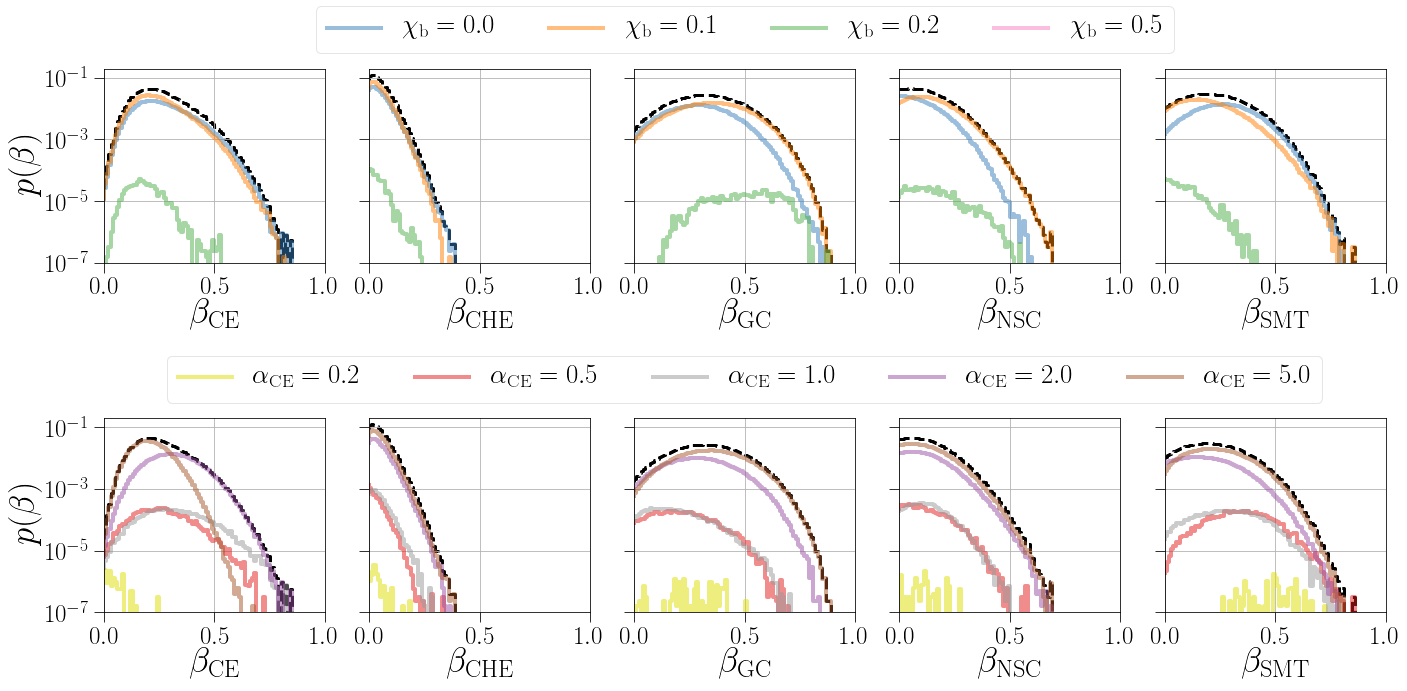

In [406]:
branching_fractions(samples, \
                labelsize=35, ticksize=25, legendsize=27)

In [405]:
0.05291 / 10**-2.8

33.38395309644701

In [342]:
# print difference in branching fractions between the two-channel and five-channel case for CE and GC

print('Percent difference in CE branching fraction: {:0.3f}'.format(100*np.abs((0.244-0.402)/0.402)))
print('Percent difference in GC branching fraction: {:0.3f}'.format(100*np.abs((0.331-0.598)/0.598)))

Percent difference in CE branching fraction: 39.303
Percent difference in GC branching fraction: 44.649


In [407]:
def largest_beta(samples, hyperidx, prior_path, labelsize=40, ticksize=30, legendsize=25):
    beta_keys = sorted([key for key in list(samples.keys()) if 'beta' in key])
    hyperidx_key = 'p'+str(int(hyperidx))

    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(3, 1)
    Bmax_ax = fig.add_subplot(gs[1:,:])
    Bvol_ax = fig.add_subplot(gs[0,:])
    
    
    ### BOTTOM ROW
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=1.0, lw=3, linestyle='--', label='posterior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=1.0, lw=3, linestyle='--')
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=1.0, lw=3, linestyle='--')
    print("99% of beta_max are below: {:0.3f}".format(np.percentile(max_betas, 99)))
    
    # get max beta for prior samples
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h, bins = np.histogram(max_betas, bins=100, range=(0,1))
    h = np.append(h, [0])
    Bmax_ax.step(bins, h/len(samples), color='k', alpha=0.4, lw=3, label='prior')
    Bmax_ax.axvline(np.percentile(max_betas, 5), color='k', alpha=0.4, lw=3)
    Bmax_ax.axvline(np.percentile(max_betas, 95), color='k', alpha=0.4, lw=3)
    print("99% of beta_max are below: {:0.3f}".format(np.percentile(max_betas, 99)))
    
    # get max betas for submodels
    for (hkey, hval) in hyperparam_dict[hyperidx_key].items():
        samples_in_hypermodel = samples.loc[samples[hyperidx_key]==hkey]
        betas = samples_in_hypermodel[beta_keys]
        max_betas = betas.max(axis=1)
        h, bins = np.histogram(max_betas, bins=100, range=(0,1))
        h = np.append(h, [0])
        Bmax_ax.step(bins, h/len(samples), color=colors[hkey], alpha=0.7, lw=4, label=hval)
        
    # format plot
    Bmax_ax.set_xlim(1/len(beta_keys),1)
    Bmax_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bmax_ax.set_ylim(0, 0.06)
    Bmax_ax.set_yticks((0, 0.02, 0.04, 0.06))
    Bmax_ax.set_xlabel(r'$\beta_{\rm max}$', fontsize=labelsize)
    Bmax_ax.set_ylabel(r'$p(\beta_{\rm max})$', fontsize=labelsize)
    Bmax_ax.tick_params(axis='both', labelsize=ticksize)
    
    Bmax_ax.legend(prop={'size':legendsize}, loc='upper right')
        
        
        
    ### TOP ROW
    prior_samps = pd.read_hdf(prior_path, key='samples')
    max_betas = prior_samps.max(axis=1)
    h_prior, _ = np.histogram(max_betas, bins=100, range=(1.0/len(beta_keys),1))   
    prior_vol = np.cumsum(h_prior[::-1])[::-1]
    
    # get max beta for all samples
    betas = samples[beta_keys]
    max_betas = betas.max(axis=1)
    h_post, bins = np.histogram(max_betas, bins=100, range=(1.0/len(beta_keys),1))
    post_vol = np.cumsum(h_post[::-1])[::-1]
    
    # print prior volume comparison
    binval = 0.8
    bin_idx = np.where(bins==binval)[0]
    print("Prior volume compared to posterior volume at beta_max={:.02f}: {:0.3f}".format(binval, float(prior_vol[bin_idx] / post_vol[bin_idx])))
    
    # get the heights and bins where there is any posterior volume
    where_theres_post = np.where(h_post > 0)[0]
    where_theres_nopost = np.where(h_post == 0)[0]
    
    bins_to_plot = np.append(bins[0], bins[1:][where_theres_post])
    bins_to_plot = np.append(bins_to_plot, [bins[where_theres_post][-1]+(bins[1]-bins[0])])
    priorpost_to_plot = np.append([1], prior_vol[where_theres_post] / post_vol[where_theres_post])
    priorpost_to_plot = np.append(priorpost_to_plot, [1e4])

    Bvol_ax.plot(bins_to_plot, priorpost_to_plot, color='k')

    # format plot
    Bvol_ax.set_xlim(1/len(beta_keys),1)
    Bvol_ax.set_xticks((np.linspace(1/len(beta_keys), 1, 5)))
    Bvol_ax.set_xticklabels([])
    Bvol_ax.set_yscale('log')
    Bvol_ax.set_ylim(9e-1, 1e4)
    Bvol_ax.set_yticks([1e0, 1e2, 1e4])
    Bvol_ax.set_ylabel(r'$\mathcal{V}$', fontsize=labelsize)
    Bvol_ax.tick_params(axis='both', labelsize=ticksize)

    
    plt.tight_layout(rect=(0, 0, 1, 1))
    plt.savefig(os.path.join(fig_path, 'beta_max.png'))

99% of beta_max are below: 0.656
99% of beta_max are below: 0.789
Prior volume compared to posterior volume at beta_max=0.80: 78.388


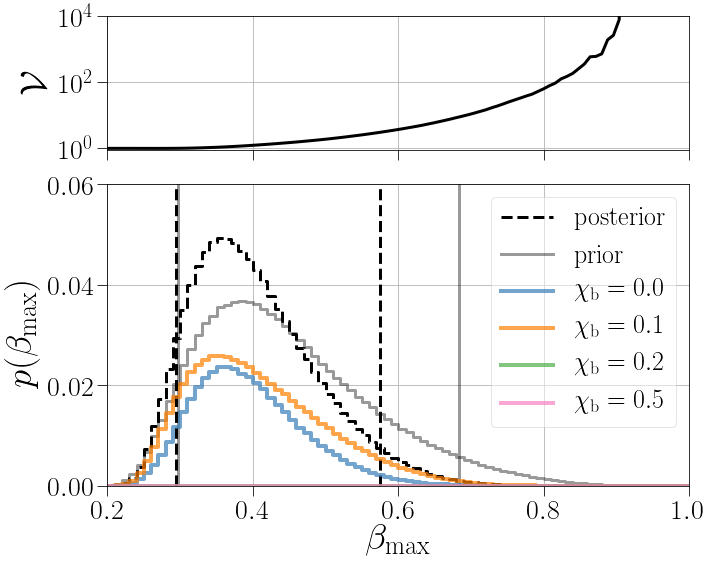

In [408]:
largest_beta(samples, 0, \
            prior_path='/Users/michaelzevin/research/model_selection/model_selection/data/prior/prior_samples_5channel.hdf5', \
            labelsize=37, ticksize=28, legendsize=26)

### Table for Bayes Factors

In [30]:
def construct_table(models, model0_dict):
    
    table = \
r'''\begin{deluxetable*}{@{\extracolsep{4pt}}c | c c c c c | c}
\label{tab:table}
\tablecaption{}
\tablehead{
\colhead{} & \colhead{$\alpha_{\rm CE}=0.2$} & \colhead{$\alpha_{\rm CE}=0.5$} & \colhead{$\alpha_{\rm CE}=1.0$} & \colhead{$\alpha_{\rm CE}=2.0$} & \colhead{$\alpha_{\rm CE}=5.0$} & \colhead{}\\
\cline
}
\startdata
'''
    p0_vals = [0,1,2,3]
    p1_vals = [0,1,2,3,4]
    
    Nsamps0 = len(samples.loc[(samples['p0']==model0_dict['p0']) & (samples['p1']==model0_dict['p1'])])
    Nsamps0_p0 = len(samples.loc[samples['p0']==model0_dict['p0']])
    Nsamps0_p1 = len(samples.loc[samples['p1']==model0_dict['p1']])
    
    for p0 in p0_vals:
        BF_vals = []
        # add values for each alphaCE
        for p1 in p1_vals:
            Nsamps = len(samples.loc[(samples['p0']==p0) & (samples['p1']==p1)])
            if Nsamps == 0:
                BF_vals.append(-100)
            else:
                BF_vals.append(np.log10(Nsamps/Nsamps0))
        # add value for this row in chi
        Nsamps = len(samples.loc[(samples['p0']==p0)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p0))
        
        # reformat the BF values
        BF_vals_formatted = []
        for BF in BF_vals:
            if BF==0:
                BF_vals_formatted.append('-')
            elif BF==-100:
                BF_vals_formatted.append('N/A')
            else:
                BF_vals_formatted.append(str(np.round(BF, 2)))
        
        temp = r'''%s & %s & %s & %s & %s & %s & %s \\
        ''' % (hyperparam_dict['p0'][p0], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4], BF_vals_formatted[5])
        table += temp

    # add values for all alphaCE columns
    BF_vals = []
    for p1 in p1_vals:
        Nsamps = len(samples.loc[(samples['p1']==p1)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p1))
    BF_vals_formatted = []
    for BF in BF_vals:
        if BF==0:
            BF_vals_formatted.append('-')
        elif BF==-100:
            BF_vals_formatted.append('N/A')
        else:
            BF_vals_formatted.append(str(np.round(BF, 2)))
    temp = temp = r'''%s & %s & %s & %s & %s & %s & %s\\
    ''' % ('', BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], BF_vals_formatted[3], BF_vals_formatted[4], '')
    table += temp
        
    temp = r'''\enddata
\end{deluxetable*}'''
    table += temp

    print(str(table))
    return

In [191]:
p1_dict = {0:'0.2', 1:'0.5', 2:'1.0', 3:'2.0', 4:'5.0'}

def construct_table(models, model0_dict):
    
    table = \
r'''\begin{table}[t]
\begin{center}
\caption{Bayes factors ($\log_{10}(\mathcal{B})$) across \chib models (columns) and \alphaCE models (rows), relative to the model with $\chib=0.0$ and $\alphaCE=1.0$. 
The bottom row provides the Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the Bayes factors for \alphaCE models marginalized over all \chib models. 
Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. \label{tab:table}}
\setlength{\tabcolsep}{8pt}
\vspace{-20pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
'''
    p0_vals = [0,1,2,3]
    p1_vals = [0,1,2,3,4]
    
    Nsamps0 = len(samples.loc[(samples['p0']==model0_dict['p0']) & (samples['p1']==model0_dict['p1'])])
    Nsamps0_p0 = len(samples.loc[samples['p0']==model0_dict['p0']])
    Nsamps0_p1 = len(samples.loc[samples['p1']==model0_dict['p1']])
    
    for p1 in p1_vals:
        BF_vals = []
        # add values for each alphaCE
        for p0 in p0_vals:
            Nsamps = len(samples.loc[(samples['p0']==p0) & (samples['p1']==p1)])
            if Nsamps == 0:
                BF_vals.append(-100)
            else:
                BF_vals.append(np.log10(Nsamps/Nsamps0))
        # add value for this row in alphaCE
        Nsamps = len(samples.loc[(samples['p1']==p1)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p1))
        
        # reformat the BF values
        BF_vals_formatted = []
        for BF in BF_vals:
            if BF==0:
                BF_vals_formatted.append(r'\equiv')
            elif BF==-100:
                BF_vals_formatted.append('-')
            else:
                BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
        
        if p1 == 0:
            temp = r'''\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        else:
            temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ \\
''' % (p1_dict[p1], BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], \
                                   BF_vals_formatted[3], BF_vals_formatted[4])
        table += temp

    table += r'''\cline{2-7}
'''
    
    # add values for all chib columns
    BF_vals = []
    for p0 in p0_vals:
        Nsamps = len(samples.loc[(samples['p0']==p0)])
        if Nsamps == 0:
            BF_vals.append(-100)
        else:
            BF_vals.append(np.log10(Nsamps/Nsamps0_p0))
    BF_vals_formatted = []
    for BF in BF_vals:
        if BF==0:
            BF_vals_formatted.append(r'\equiv')
        elif BF==-100:
            BF_vals_formatted.append('-')
        else:
            BF_vals_formatted.append('{:0.2f}'.format(np.round(BF, 2)))
    temp = r'''& \multicolumn{1}{l|}{$%s$} & $%s$ & $%s$ & $%s$ & \multicolumn{1}{l|}{$%s$} & $%s$ ''' \
            % ('', BF_vals_formatted[0], BF_vals_formatted[1], BF_vals_formatted[2], BF_vals_formatted[3], '')
    table += temp

    temp = r'''
\end{tabular}
\end{center}
\end{table}'''
    table += temp

    print(str(table))
    return

In [192]:
construct_table(samples, {'p0':0, 'p1':2})

\begin{table}
\begin{center}
\caption{Bayes factors ($\log_{10}(\mathcal{B})$) across \chib models (columns) and \alphaCE models (rows), relative to the model with $\chib=0.0$ and $\alphaCE=1.0$. 
The bottom row provides the Bayes factors for \chib models marginalized over all \alphaCE models, and the rightmost column provides the Bayes factors for \alphaCE models marginalized over all \chib models. 
Bayes factors are marked as `$-$' when no samples are in the given model, implying a strongly negative Bayes factor of $\log_{10}(\mathcal{B}) < -4.68$. \label{tab:table}}
\setlength{\tabcolsep}{8pt}
\begin{tabular}{c c c c c c c} 
& & \multicolumn{4}{c}{$\chi_{\rm b}$} & \\
& \multicolumn{1}{l|}{} & $0.0$ & $0.1$ & $0.2$ & \multicolumn{1}{l|}{$0.5$} & \\
\cline{2-7}
\multirow{5}{*}{$\alpha_{\rm CE}$} & \multicolumn{1}{l|}{$0.2$} & $-2.82$ & $-2.68$ & $-$ & \multicolumn{1}{l|}{$-$} & $-2.72$ \\
& \multicolumn{1}{l|}{$0.5$} & $0.16$ & $-0.72$ & $-$ & \multicolumn{1}{l|}{$-$} & $-0.06$ \\
& 